<a href="https://colab.research.google.com/github/likoscp/face_detection/blob/main/Face_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
faces_zip = "/content/drive/MyDrive/face.zip"
robots_zip = "/content/drive/MyDrive/robots.zip"
animal_zip = "/content/drive/MyDrive/animal.zip"
items_zip = "/content/drive/MyDrive/items.zip"
fake_faces_zip = "/content/drive/MyDrive/fake_faces.zip"
anime_faces_zip = "/content/drive/MyDrive/anime_faces.zip"

!mkdir -p /content/dataset/face
!mkdir -p /content/dataset/robots
!mkdir -p /content/dataset/animal
!mkdir -p /content/dataset/items
!mkdir -p /content/dataset/fake_faces
!mkdir -p /content/dataset/anime_faces

!unzip -qo $faces_zip -d /content/dataset/face
!unzip -qo $robots_zip -d /content/dataset/robots
!unzip -qo $animal_zip -d /content/dataset/animal
!unzip -qo $items_zip -d /content/dataset/items
!unzip -qo $fake_faces_zip -d /content/dataset/fake_faces
!unzip -qo $anime_faces_zip -d /content/dataset/anime_faces

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, datasets
import matplotlib.pyplot as plt
import os, shutil
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def split_dataset(src_dir, dst_root, class_name, split=(0.7,0.2,0.1)):
    files = os.listdir(src_dir)
    np.random.shuffle(files)

    n_total = len(files)
    n_train = int(split[0] * n_total)
    n_val = int(split[1] * n_total)

    train_files = files[:n_train]
    val_files = files[n_train:n_train+n_val]
    test_files = files[n_train+n_val:]

    for subdir in ["train", "val", "test"]:
        os.makedirs(os.path.join(dst_root, subdir, class_name), exist_ok=True)

    for f in train_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_root, "train", class_name, f))
    for f in val_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_root, "val", class_name, f))
    for f in test_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_root, "test", class_name, f))

In [ ]:
split_dataset("/content/dataset/face", "/content/dataset_", "face")
split_dataset("/content/dataset/face", "/content/dataset_ready", "face")
split_dataset("/content/dataset/robots", "/content/dataset_ready", "robots")
split_dataset("/content/dataset/animal", "/content/dataset_ready", "animal")
split_dataset("/content/dataset/items", "/content/dataset_ready", "items")
split_dataset("/content/dataset/fake_faces", "/content/dataset_ready", "fake_faces")
split_dataset("/content/dataset/anime_faces", "/content/dataset_ready", "anime_faces")


In [ ]:
# from PIL import Image

# data_dir = "/content/dataset/face"
# max_size = (1280, 1280)

# def resize_big_images(data_dir, max_size=(1280,1280)):
#     for root, dirs, files in os.walk(data_dir):
#         for f in files:
#             path = os.path.join(root, f)
#             try:
#                 img = Image.open(path)
#                 if img.size[0] * img.size[1] > 894788:
#                     print(f"Resizing {path} from {img.size}...")
#                     img.thumbnail(max_size, Image.Resampling.LANCZOS)
#                     img.save(path)
#             except Exception as e:
#                 print(f"Error с {path}: {e}")

# resize_big_images(data_dir, max_size=(1280,1280))


In [ ]:
dataset_root = "/content/dataset_ready"
img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    dataset_root + "/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_directory(
    dataset_root + "/val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    dataset_root + "/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(train_gen.num_classes, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])



early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop]
)

test_loss, test_acc = model.evaluate(test_gen)
print(f"Test accuracy: {test_acc:.4f}")

model.save("/content/simple_cnn.h5")


Found 654 images belonging to 6 classes.
Found 186 images belonging to 6 classes.
Found 98 images belonging to 6 classes.
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.3111 - loss: 1.6238 - val_accuracy: 0.5430 - val_loss: 1.0721
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5086 - loss: 1.1740 - val_accuracy: 0.6075 - val_loss: 0.9929
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5502 - loss: 1.0483 - val_accuracy: 0.6774 - val_loss: 0.9040
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6084 - loss: 0.9638 - val_accuracy: 0.6774 - val_loss: 0.7645
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6311 - loss: 0.9128 - val_accuracy: 0.6935 - val_loss: 0.8428
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6334 - loss: 0.9656 - val_accuracy: 0.7258 - val_loss: 0.7752
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6656 - loss: 0.8839 - val_accuracy: 0.7204 - val_loss: 0.7

Test accuracy: 0.6224


In [ ]:
# !rm -rf /content/dataset


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


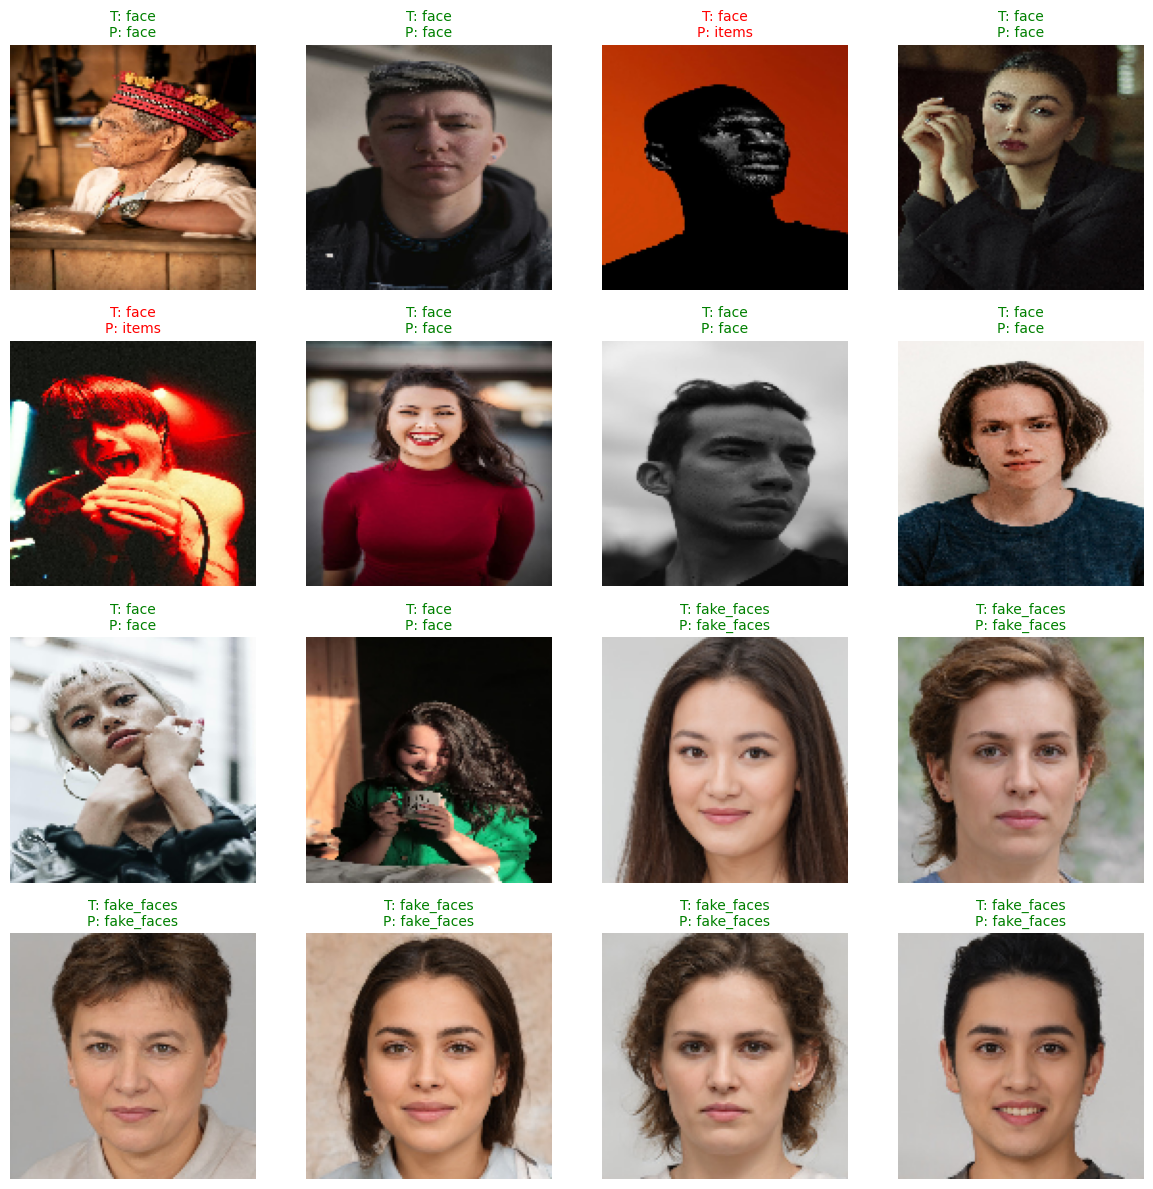

In [ ]:
class_names = list(train_gen.class_indices.keys())
x_batch, y_batch = next(test_gen)
y_true = np.argmax(y_batch, axis=1)
y_pred = np.argmax(model.predict(x_batch), axis=1)
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_batch[i])
    plt.axis("off")
    true_label = class_names[y_true[i]]
    pred_label = class_names[y_pred[i]]
    color = "green" if y_true[i] == y_pred[i] else "red"
    plt.title(f"T: {true_label}\nP: {pred_label}", color=color, fontsize=10)
plt.tight_layout()
plt.show()